In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from pathlib import Path

np.random.seed(42)


In [2]:
plt.rcParams["figure.figsize"] = (50,10)
sns.set_context("poster")
sns.set_style("ticks")
#sns.set_style("dark")
sns.despine()


<Figure size 3600x720 with 0 Axes>

In [3]:
iters = 100
l2 = 1
n_std = 4
epochs = 100# 500#10000#1000

np.random.seed(42)

# How to build object oriented ensembles with Pytorch

## Intro

## Why?
researching Predictive uncertainty means implementing many models that are somewhat alike - and more importantly, for them to be comparable, we want them to have as much shared code as possible to avoid bugs, accidental misspeciications and to make it easy to verify that they are indeed 'similar enough' to be compared (imagine for example two neural networks with different numbers of neurons in different numbers of layers with different activation functions optimized by different algorithms according to different criteria - we want to controll the non-essential variables as good as possible!

## What?
building ensembles up from a simple parent ensemble class. This way, the ensembles can inherit everything except the things that are actuvely being changed for experimentation. This has the benefit of making explanations incredibly straight forward once the parent was understood!

## how?
Parent class - child classes. 


## The Basics

## Problem

Regression

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### Predictive Uncertainty

### Ensembles

#### a quick primer on ensembling theory

The parent ensemble is a simple one - in depth descriptions can for example be obtained from zhang2012ensemble.
Ensembles are very successfully and effectively used in methodds like Forests or GradientBoosting methods, however, ensembling neural Networks is generally consideres <write somthing>...
    
The basic idea is to train <n_models> models on the same dataset and to then combine them during the prediction phase.

Classically, this has been done to obtain the predictive mean of the models,

$$ \mu_i = \frac{1}{N}\sum_{i=1}^N \hat{y_i} $$ (where N is the number of ensemble members, $\mu_i$ is the predictive mean for a data point and $\hat{y_i}$ is the prediction of the ith ensemble member).
However, being interested in predictive uncertainty, one approach is to also compute the disagreements between the models and use this as a measure of predictive uncertainty:

$$ \sigma_i = \sqrt{\frac{\sum_{i=1}^N (\mu_i - y_i)^2}{N-1}} $$
    
    

#### Ensembles in classification (voting theorems, bonus content)

#### Model Diversity - why
In order for the predictive uncertainty obtained in this way to be meaningful, the ensemble producing them has to be diverse but of roughly equal quality.
It's not hard to imagine how an ensemble consisting of very similar or even the same models leads to degenerate variance, making it impossble to specify a non-degenerate distribution over values that would be of any use. In the end, the model would just be 100% certain about it's predictions, which doesn't really help us - we want to knoe exactly when the model is not sure about it's prediction (and we hope that this correlates with actual likelyhood of error, otherwise the amount of useable information is very low).

On the other hand, in an ensemble made of different models of very varying quality, we'd expect the quality of the prediction to suffer, as bad models fail to capture the structure of the underlying processes and pull down the prediction itself
(although there is a special case to be considered - if a model is fantastic at predicting a minority of very hard cases that the other models fail to deliver, it cn be of incredible value for the ensemble. However, this is an advanced topic in ensembling theory and won't be covered now)


#### Model diversity - how?
While there are numerous (and sometimes strenuous) ways of generating ensembles that pass on those two criteria (diversity and equality) exist (the gold standard probably being building a bunch of models from scratch, train them on the dataset, go through the process of optimizing their parameters, retrain, test again, throw out underperforming models, get frustrated because ohnly two models are left which isn't enough for anythin meningful, repeat), in this article we'll be looking at the following ones:

1. ensembling through different initialisation values
2. ensembling through different shufflings of data
3. ensembling through bootstrapping the data
4. ensembling through time ([Bobstrap](https://www.goodreads.com/series/192752-bobiverse))
5. 'ensembling with extreme parameter sharing': dropout MCMC

Others to come?

## The Data

As mentioned before, we are focussing on regression (as I personally find it more interesting than classification, and because it's easier [read: more intuitive] to visualise the uncertainties involved).
The dataset we'll be looking at is generated by creting X values between 0 and 1, giving them a padding left and right (so we can see how the uncertainty behaves outside of observed data), one 'out-of-sample' datapoint so we can see how that affects the  uncertainty and then running a combination of two sinoids (scaled) plus gaussian noise to generate the y values.

In [4]:
def generate_data(datalen=1000,noise_level=0.2,padding_size=10, out_of_sample = True) -> np.array:
    """returns numpy arrays X and y that can be used as basis for regression problem"""
    
    # original X, datalen points between 0 and 1
    X_long = np.linspace(0,1,datalen)
    
    #actual X that we use - padded left and right
    X = X_long[padding_size:]
    X = X[:len(X) - padding_size]  
    

    if out_of_sample:
        # add the first and last datapoints back to X to have out of sample datapoint
        X = np.insert(X,0,X_long[0])
        X = np.append(X,X_long[-1])

    # define the frequencies of the sinoid
    freq1 = 0.1
    freq2 = 0.0375
    
    # make some noise!
    noise = np.random.randn(len(X)) * noise_level
    
    # the function that generates y
    def generate_y(X_):
        """nonlinear case"""
        X_ = X_ * 200
        y1 = np.sin(X_ * freq1) 
        y2 = np.sin(X_ * freq2) 
        return y1 + y2
    
    def generate_y_linear(X_):
        """linear case"""
        return X_/datalen
    
    # the original function values
    y_long = generate_y(X_long)
    
    # it all comes together: generated function plus noise
    y = generate_y(X) + noise
    X = np.expand_dims(X,1)
    X_long = np.expand_dims(X_long,1)
    
    y = np.expand_dims(y,1)
    y_long = np.expand_dims(y_long,1)

    return X, y, X_long, y_long

In [5]:
import pandas as pd
from scipy import stats

def load_data(scale_y = True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df = pd.read_csv('train.csv').select_dtypes(include=numerics).dropna()
    
    #remmove outliers
    q = df["SalePrice"].quantile(0.99)
    df = df[df["SalePrice"] < q]

    #df
    
    print(df.shape)
    
    y = df['SalePrice']
    X = df.drop('SalePrice',axis=1)
    
    def normalize(df,minmax=False):
        if minmax:
            return (df-df.min())/(df.max()-df.min())
        
        return (df-df.mean())/df.std()

    
    # normalize
    X = normalize(X)
    if scale_y:
        y = normalize(y)
        
        

    return X.values,y.values


In [6]:
X,y = load_data()

N = X.shape[0]

(1109, 38)


In [7]:
y = np.expand_dims(y,1)

In [8]:
X.shape, y.shape

((1109, 37), (1109, 1))

In [9]:
np.isnan(X).mean()

0.0

In [10]:
# X,y,X_long,y_long = generate_data(N,0.3)

In [11]:
# plt.plot(X,y,'x',label='observed values',c='black')
# plt.plot(X_long, y_long,label='generating function',c='r')
# plt.title('the Dataset')
# plt.xlabel('this is between 0 and 1')
# plt.ylabel('this is a combination of two sioids and a bit of noise')
# plt.legend()

## The Code

As mentioned briefly, the code is written to rely heavily on inheritance, with one parent class defining the essence of what an ensemble is, how it is trained and how we obtain a predictive mean and uncertainty from it. 

Where the models differ (for example in the training method of the bootstrap ensemble compared to the parent), we ONLY need to modify that particular piece of code. This SURELY !!MUSST!! lead to bug- and error free code. Right? RIGHT?!??


#### Helpers

plots the model and the uncertainty. Only interesting parameter: n_std is the number of standard deviations to show.

In [12]:
def plot_uncertainty(model,n_std=4,raw=False, sort=True):
    
    X_ = np.arange(len(y))
    
    if sort==True:
        index = np.argsort(y.squeeze())
    else: 
        #just use index [0,1,2,3,4,...]
        index = X_


    fig, ax = plt.subplots(1,1)
    if raw:
        try:
            y_mean, y_std = model.uncertainty_function(X, iters, l2=l2,raw=True)
        except Exception as e:
            print(f"this network has no raw uncertainty. Please consider using DropoutEnsembles instead, {e}")
    else:
            y_mean, y_std = model.uncertainty_function(X, iters, l2=l2)


    ax.plot(X_, y[index], ls="none", marker="x", color="black", label="observed",ms =7)
    #ax.plot(X_, y, ls="-", color="r", label="true")
    ax.plot(X_, y_mean[index], ls="none", color="purple", label="mean",marker="_")
    ax.errorbar(X_, y_mean[index] , yerr=y_std[index].squeeze(), label='unctertainty',color="purple",alpha=0.1,marker="_",uplims=True, lolims=True,fmt='none')
    

#     for i in range(n_std):
#         ax.fill_between(
#             X_.squeeze(),
#             y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
#             y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
#             color="purple",
#             alpha=0.1
#         )




    ax.legend()
    sns.despine(offset=10)

### the model being ensembled
the model is a simple pytorch sequential model wrapped in their object layer through the torch.nn.Module. The only noteworthy parameters are the dropout_p which will be relevant for the last ensemble, the decay rate that makes sure our learnig rate diminishes and the choice of non-linearity which makes for a interesting comparisson of uncertainties WITHIN ensemble classes (might be another series...)

More about the API can be found here: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html



#### fit_model()



In [13]:

class SimpleModel(torch.nn.Module):
    """base NN model used in ensembles"""
    def __init__(self,p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.criterion = torch.nn.MSELoss()

        self.f = torch.nn.Sequential(
            torch.nn.Linear(X.shape[1],20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 10),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(10,1)
        )
        
        self.optimizer = torch.optim.Adam(
            self.parameters(),
            weight_decay=self.decay) 
        
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)
    
    
    def fit_model(self, X_obs,y_obs):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss

In [14]:

class SimpleModel(torch.nn.Module):
    """base NN model used in ensembles"""
    def __init__(self,p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.criterion = torch.nn.MSELoss()

        self.f = torch.nn.Sequential(
            torch.nn.Linear(X.shape[1],100),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(100,50),
            non_linearity(),            
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(50, 50),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(50, 15),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(15,1)
        )
        
        self.optimizer = torch.optim.Adam(
            self.parameters(),
            weight_decay=self.decay) 
        
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)
    
    
    def fit_model(self, X_obs,y_obs):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss

# d
## Gridsearch optimal params
## add cobeau etc

### Parent Ensemble

the parent ensemble class (called vanilla because it's really basic) contains the topics we've talked about before, in code:

#### __init__()
in this function, we generate a list of models to be used by the ensemble by calling SimpleModel with basic parameters n_models time. Note that by default they are assigned different initialisation values, thus making this our first possibly useable ensemble! 
We also make sure that we have a corresponding number of optimizers, this is a bit awkward and will likely be changed in future releases.



#### fit_model()
to establish an method-agnostic API, we call the function that trains the neural net fit_model - that means we will not be limited to ensembles in further endeavours.

all it does is go through the list of models (and optimizers -.- will be changed don't get used to it) and call fit_ensemble_member(model, optimizer, X,y)


#### fit_ensemble_member()
This is where the magic happens. It's also a little clunky still.
The input vectors are cast to torch tensors, the ensemble member (model) is being called via torch prediction API (plus some dimensionality magic). This trains each model on all the data.

#### ensemble_uncertainity_estimate()
simply does what we've described above:
it makes a prediction with each model, stores the values and computes the mean and variance as predictive mean and standard deviation, returning an approximation of a distribution over values the ensemble considers likely.





In [15]:

class VanillaEnsemble(object):
    def __init__(self,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None):

        self.models = [SimpleModel(p,decay,non_linearity) for model in range(n_models)]
        self.optimizers = [torch.optim.Adam(
            model.parameters(),
            weight_decay=model.decay) for model in self.models]
        self.criterion = torch.nn.MSELoss()
        self.dropout_p = p
        self.decay = decay
    
    def fit_model(self, X_abs, y_abs):
        losslist = []
        for model,optimizer in zip(self.models,self.optimizers):
                        
            losslist.append(self.fit_ensemble_member(model, optimizer, X_abs,y_abs))
            
        return losslist
    
    def fit_ensemble_member(self, model, optimizer, X_obs,y_obs):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = model(X_obs[:, np.newaxis])
        optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        return loss      

    def ensemble_uncertainity_estimate(self,X, iters, l2=0.005, range_fn=trange):
        outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for model in self.models])
        y_mean = outputs.mean(axis=1)
        y_variance = outputs.var(axis=1)
        #tau = l2 * (1-self.dropout_p) / (2*N*self.decay)
        #y_variance += (1/tau)
        y_std = np.sqrt(y_variance)# + (1/tau)
        return y_mean, y_std
    
    
    def uncertainty_function(self,X, iters, l2, range_fn=trange):
        return self.ensemble_uncertainity_estimate(X=X, iters=iters, l2=l2, range_fn=trange)
    

    
    def shuffle(self,X,y,seed=None):
        arr = np.arange(len(y))
        if seed != None:
            np.random.shuffle(arr)
        else:
            np.random.seed(seed)
            np.random.shuffle(arr)
 
        return X[arr], y[arr]


    

In [16]:
vanilla = VanillaEnsemble()

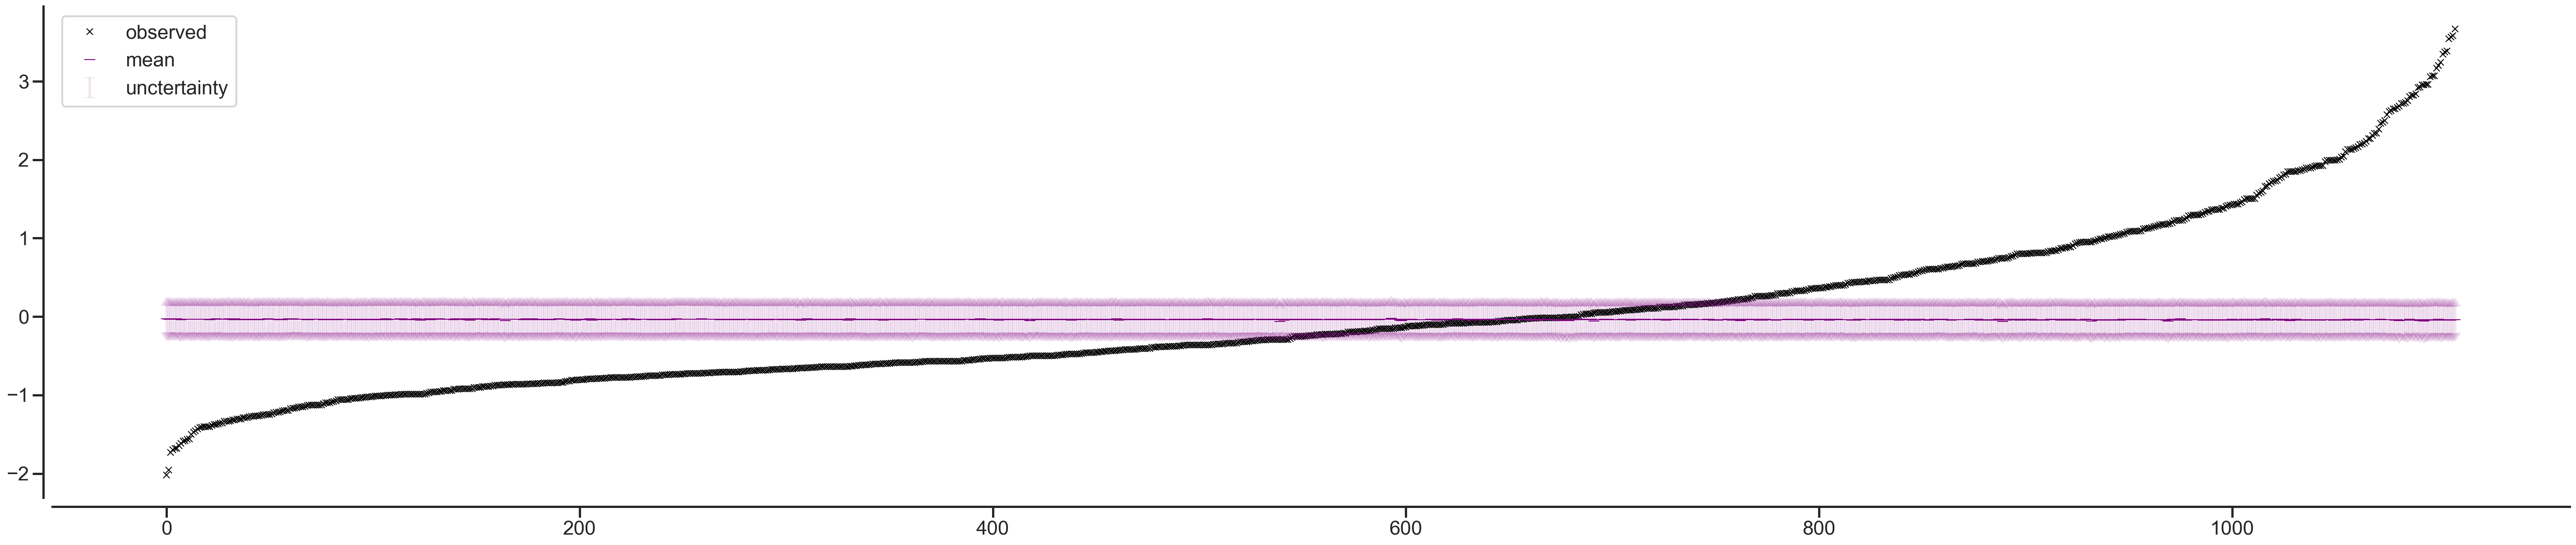

In [17]:
plot_uncertainty(vanilla)

In [18]:
y_mean, y_std = vanilla.uncertainty_function(X, iters, l2=l2)


In [19]:
#y_mean

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.35it/s]


final loss: [tensor(0.0898, grad_fn=<MseLossBackward>), tensor(0.0770, grad_fn=<MseLossBackward>), tensor(0.0751, grad_fn=<MseLossBackward>), tensor(0.0791, grad_fn=<MseLossBackward>), tensor(0.0742, grad_fn=<MseLossBackward>), tensor(0.0854, grad_fn=<MseLossBackward>), tensor(0.0952, grad_fn=<MseLossBackward>), tensor(0.0788, grad_fn=<MseLossBackward>), tensor(0.0785, grad_fn=<MseLossBackward>), tensor(0.0728, grad_fn=<MseLossBackward>)]
Wall time: 8.85 s


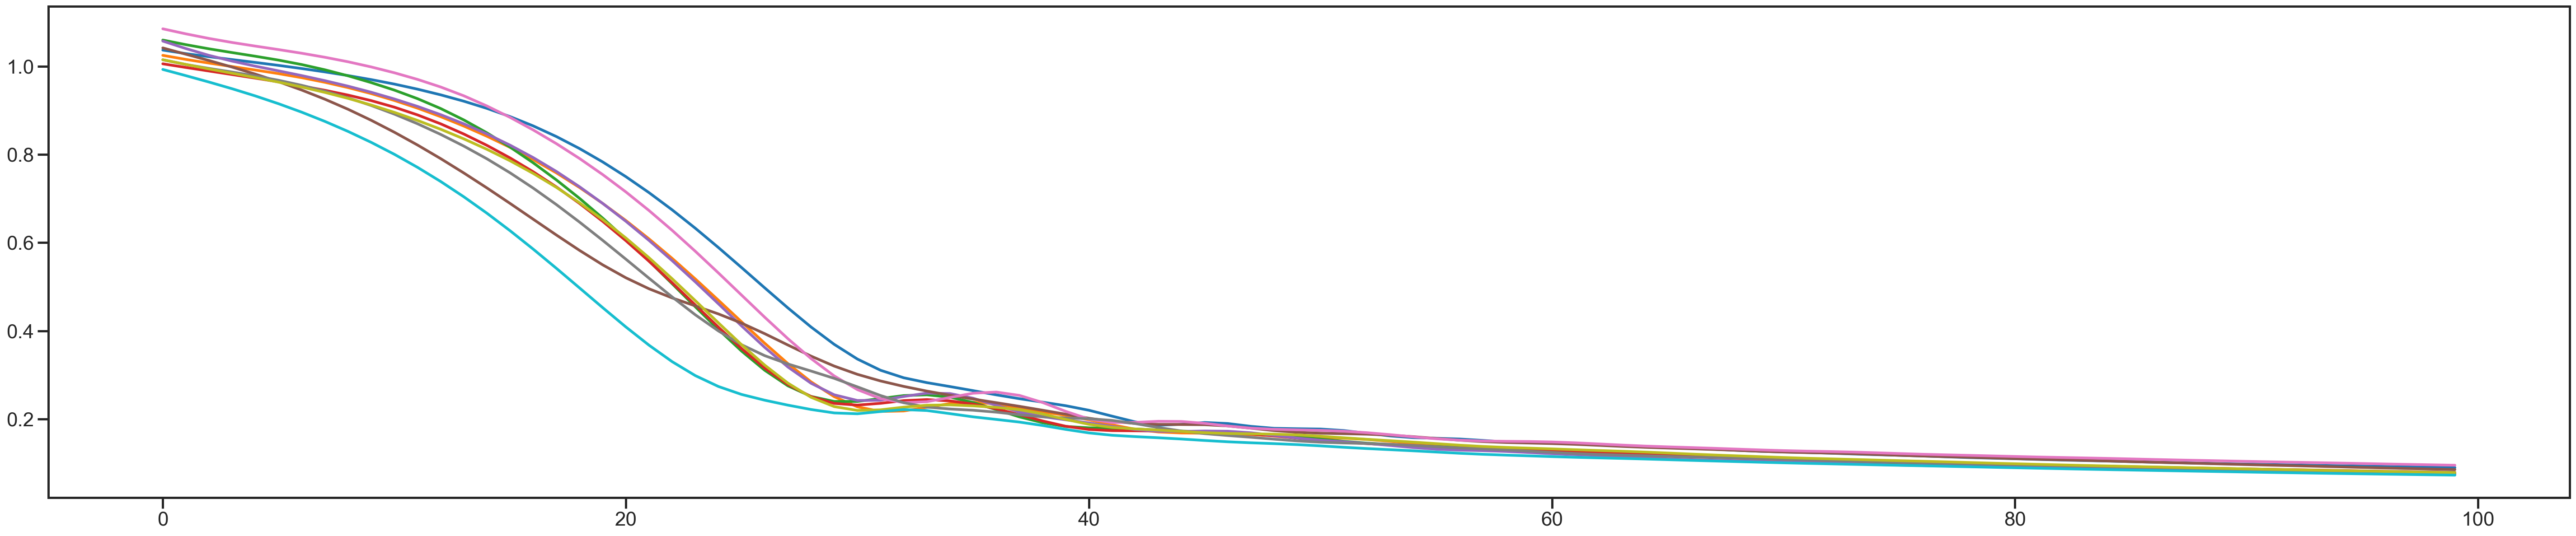

In [20]:
%%time

losses = []

for i in trange(epochs):
    losses.append(vanilla.fit_model(X,y))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [21]:
#losses

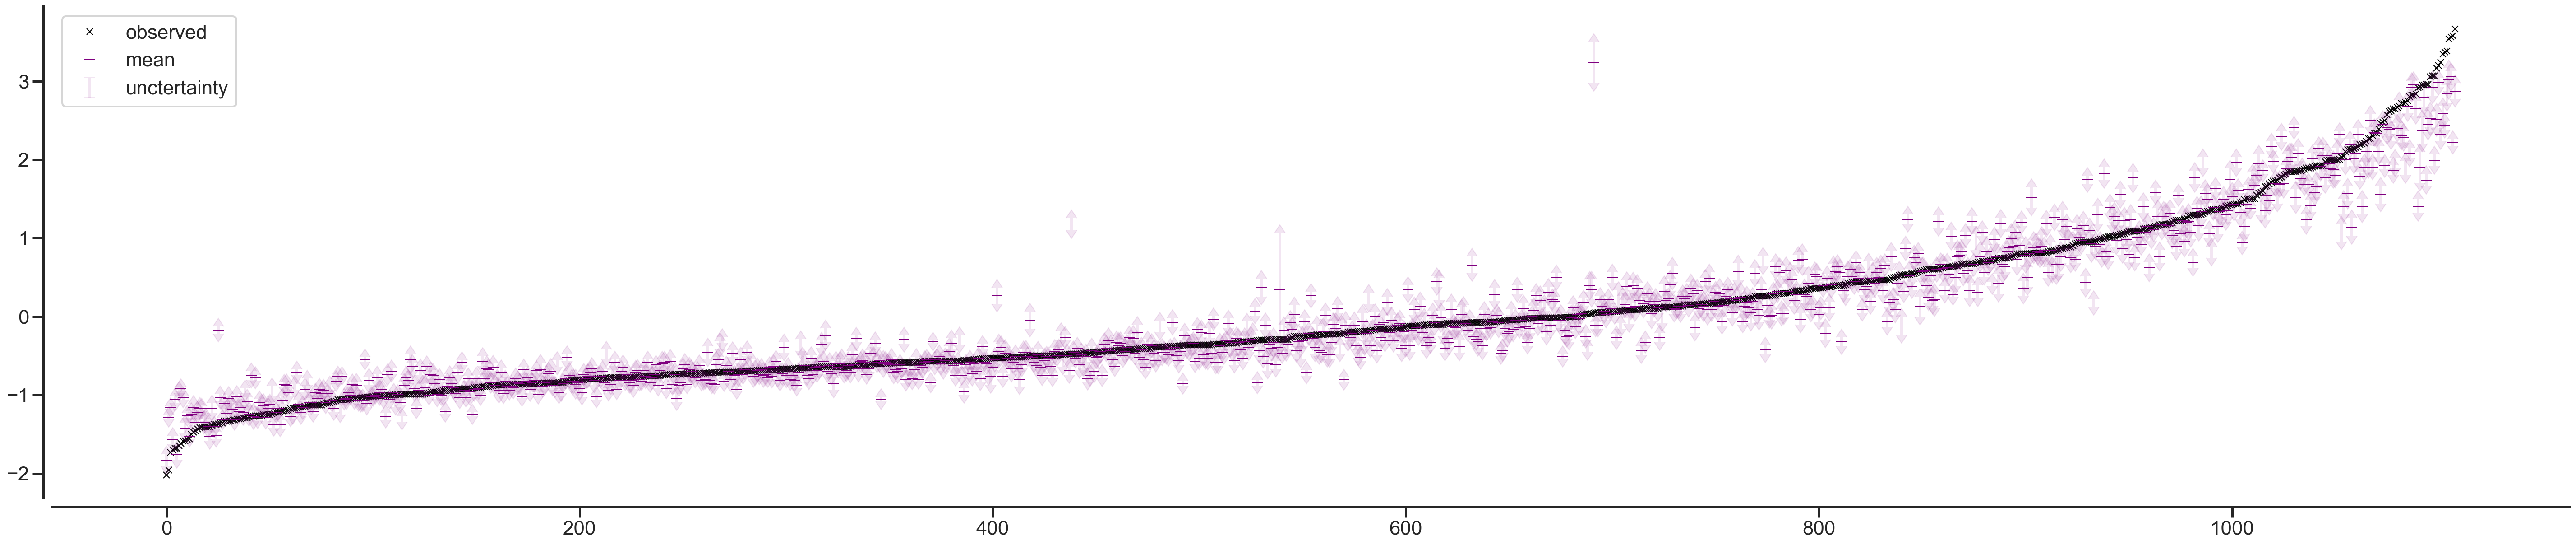

In [22]:
plot_uncertainty(vanilla)

### Shuffle Ensemble

This ensemble is very similar to our parent, the only difference:
the data is getting shuffled differently (cite this one paper about shuffling being effective in neural networks).
Since this means that the data arrives in a different order, the weights of the network will be modified slightly different by each step of the gradient descent, leading to a more diverse ensemble.
Note, however, that our dataset is REALLY small, so we're not likely to see incredible differences compared to the vanilla one

#### fit_mode()

like in the parent, we go through the list of models and optimizers and train them on each X,y pair. The difference: this time we shuffle X and y in unison differently for each member (enforced by setting a seed)

In [23]:

    
class ShuffleEnsemble(VanillaEnsemble):


    def fit_model(self, X_abs, y_abs):
        losslist = []
        for i,(model,optimizer) in enumerate(zip(self.models,self.optimizers)):
            
            shuffled_X, shuffled_y = self.shuffle(X_abs,y_abs,seed=i)
            
            losslist.append(self.fit_ensemble_member(model, optimizer, shuffled_X, shuffled_y))
        return losslist
    
   

In [24]:
shuffle = ShuffleEnsemble()

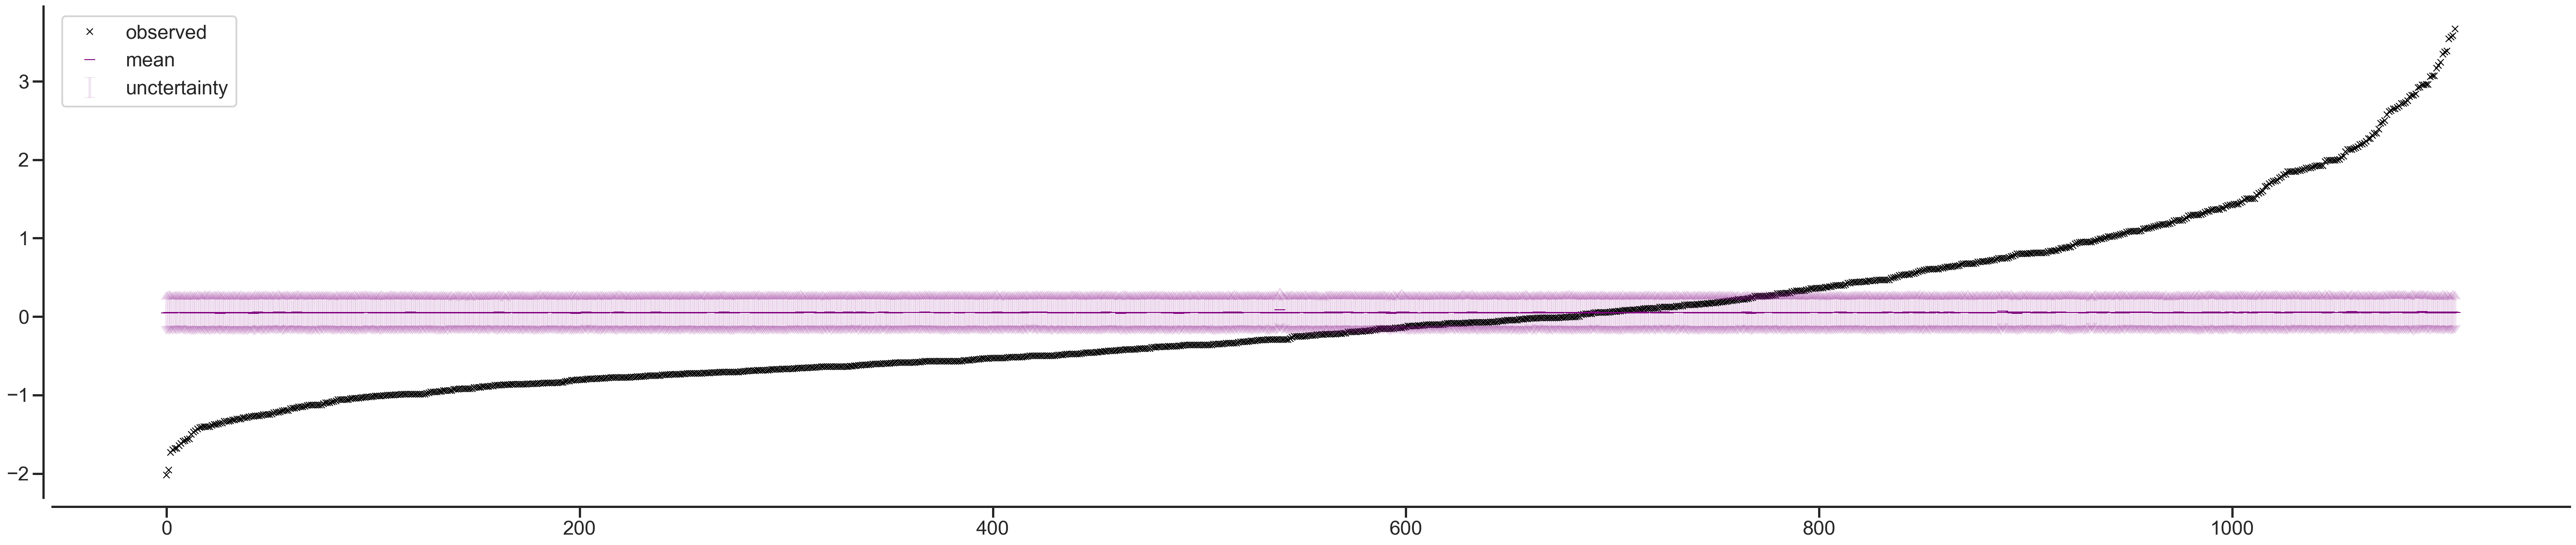

In [25]:
plot_uncertainty(shuffle)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.73it/s]


final loss: [tensor(0.0934, grad_fn=<MseLossBackward>), tensor(0.0975, grad_fn=<MseLossBackward>), tensor(0.0725, grad_fn=<MseLossBackward>), tensor(0.0756, grad_fn=<MseLossBackward>), tensor(0.1000, grad_fn=<MseLossBackward>), tensor(0.0750, grad_fn=<MseLossBackward>), tensor(0.0804, grad_fn=<MseLossBackward>), tensor(0.0744, grad_fn=<MseLossBackward>), tensor(0.0860, grad_fn=<MseLossBackward>), tensor(0.0744, grad_fn=<MseLossBackward>)]
Wall time: 8.58 s


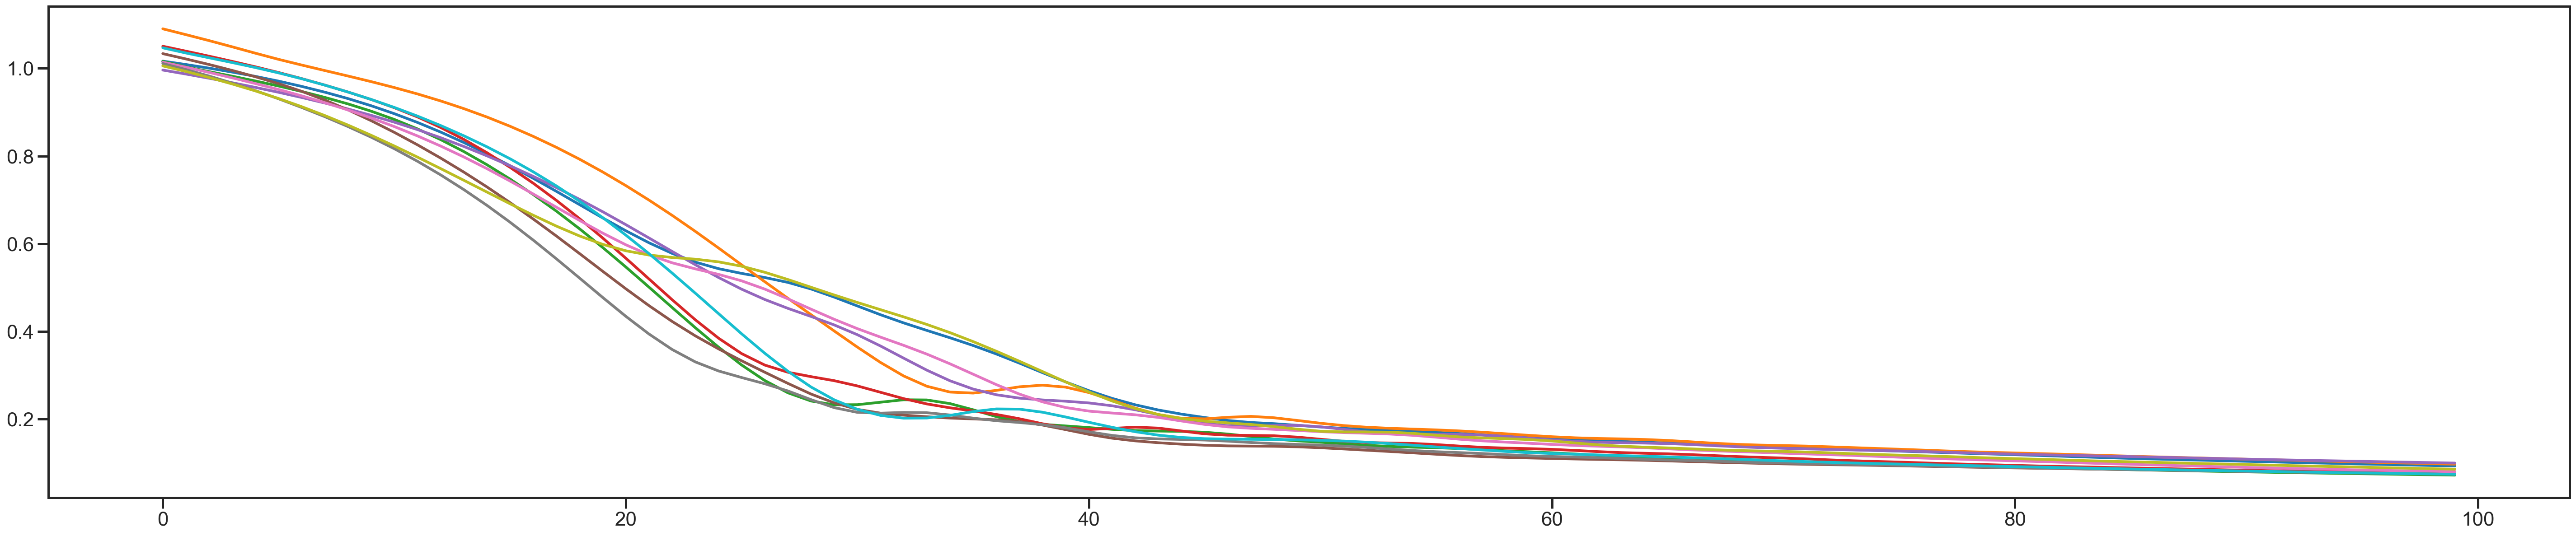

In [26]:
%%time

losses = []

for i in trange(epochs):
    losses.append( shuffle.fit_model(X,y))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

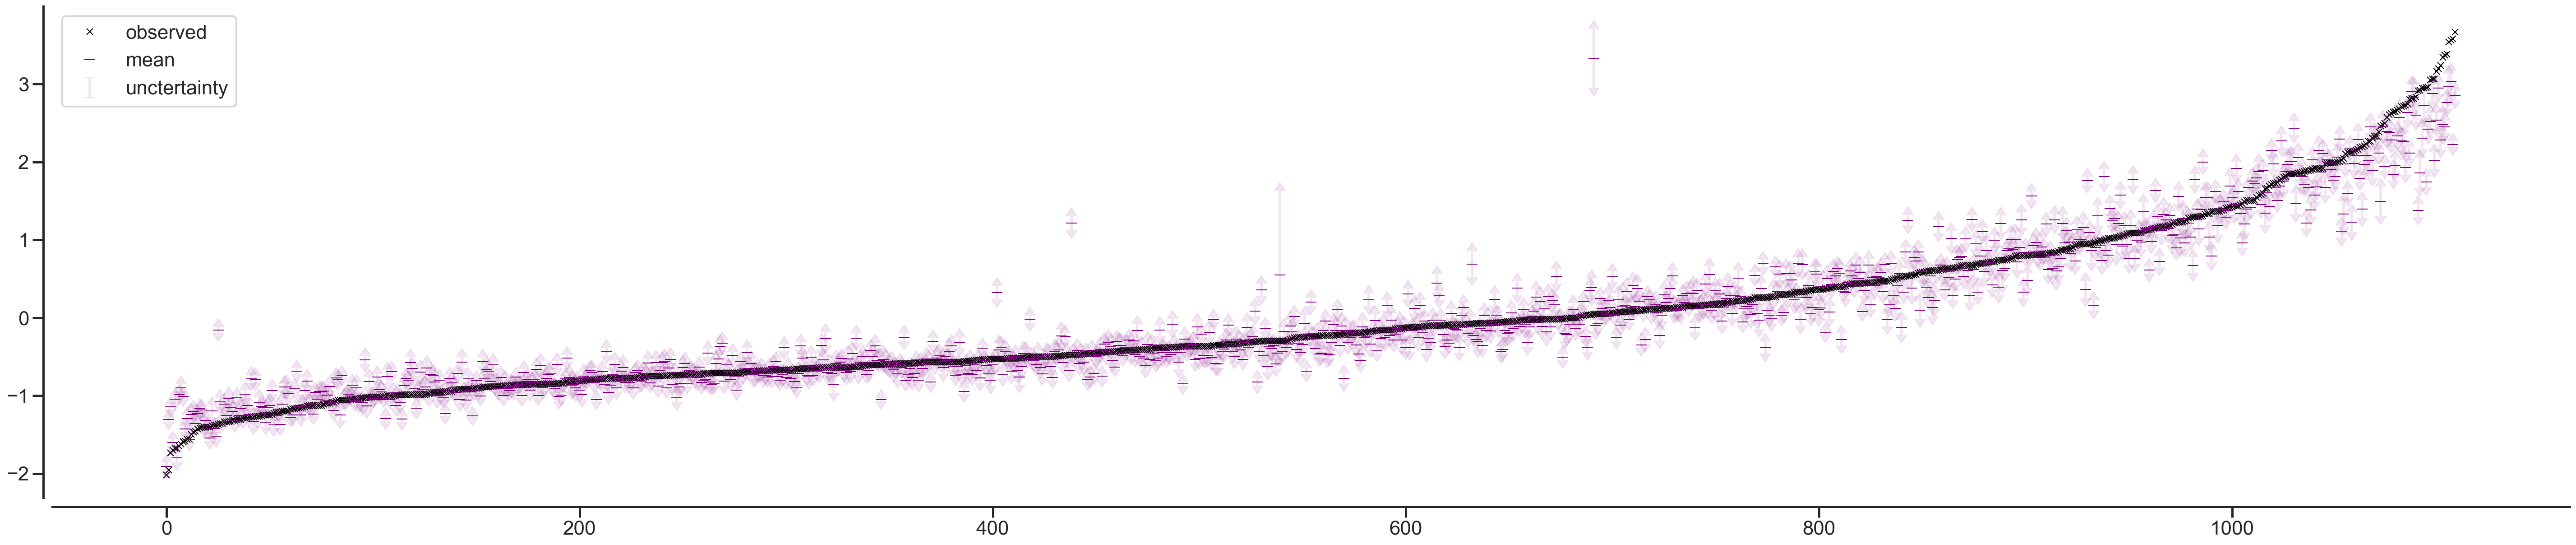

In [27]:
plot_uncertainty(shuffle)

### The Bootstrap

The Bootstrap is one of the most successful (and early) approaches to ensembling: in oder to enforce diversity among the ensemble, we partition the data in randomly shuffled portions (in our case of ~70% of the original data set) and train different models on each of the subsampled datasets.

#### __init()__
in addition to the original values, we give this ensemble a fraction of the dataset to sample (default is 0.7). 
The ensemble then generates indices that are used to access the relevant datapoints for each model. Because of this approach (there are other, but this one is mine [actually I hate it but it's quick]), the model needs to be aware of how much data it'll receive so it can pre-build the dataset. This isn't an inherent restriction but one of the current implementation. Others, like making the decision for each datapoint during run time have other benefits and disadvantages (although - this disadvantage is quite big)


#### fit_model()

only addition here is that during each training pass for each model, we choose a sub-set of the data via the index that is unique to each model (...and optimizzer :( ). Important: Every model ONLY sees it's own dataset, ever. Unless there's a bug.

In [28]:
 
    
class BootstrapEnsemble(VanillaEnsemble):
    def __init__(self,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=4, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None,bootstrap_p_positive=0.7):
        super(BootstrapEnsemble, self).__init__(p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None)
        
        self.dataset_lenght = dataset_lenght
        self.bootstrap_dataset_indices = [np.random.choice(a=[True, False], size=dataset_lenght, p=[bootstrap_p_positive, 1-bootstrap_p_positive]) for model in self.models]


    def fit_model(self, X_abs, y_abs):
        losslist = []
        for model,optimizer,indices in zip(self.models,self.optimizers,self.bootstrap_dataset_indices):
            
            X_bootstrapped, y_bootstrapped = X_abs[indices], y_abs[indices]

            
            #shuffled_X, shuffled_y = self.shuffle(X_bootstrapped, y_bootstrapped)
            shuffled_X, shuffled_y = X_bootstrapped, y_bootstrapped

            
            losslist.append(self.fit_ensemble_member(model, optimizer, shuffled_X, shuffled_y))
        return losslist
    
        

In [29]:
bootstrap = BootstrapEnsemble(dataset_lenght = len(X))

In [ ]:
plot_uncertainty(bootstrap)

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append( bootstrap.fit_model(X,y))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(bootstrap)

### Ensemble through time
We ensemble the model with itself from X iterations ago.

Oh Bot. Changes. [david bowie changes]


#### __init__()
num_epochs_per_save: everytime this is met, we save the model

current_epoch: keep track of current epoch

path: path to save the models to, important. Also nasty because it doesn't get auto-deleted at the moment. Viewer discretion advised.

model_paths: the paths of the models that are currently being used for the ensemble

#### fit_model()

fits the model in the same way the ensemble members are being fitted - with one notable exception: each time current_epoch is naturally diisible by num_epochs_per_save, we take a snapshot of the current model and store it in save path for later ensembling use. oath is saved in model_paths.

#### load_saved_model()
overwrites the current model with the one specified in the path (torch is cool with this!). necessary for the ensembling.

#### ensemble_uncertatiny_estimate()

This is where the fun is!
during prediction time, the ensemble goes through the last few stored models, loads them, attempts a prediction on the dataset and stores the outcome.
These predictions are then handled just like the other ensembles - meaning we get a free predictive uncceratiny just by saving the models every once in a while. 

A similar approach can be found in snapshot ensembles, microsoft paper?


In [ ]:
    
class SaverModel(SimpleModel):
    def __init__(self,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, num_epochs_per_save=100,save_path = 'dummytest/',n_models_to_keep=10):
        super(SaverModel, self).__init__(p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU)
        self.num_epochs_per_save = num_epochs_per_save
        self.current_epoch = 0
        
        #make sure save path exists
        path = Path().absolute()/save_path
        path.mkdir(exist_ok=True)
        self.save_path = path
        self.n_models_to_keep = n_models_to_keep

        self.model_paths = []
        
        
        
    def fit_model(self, X_obs,y_obs):
        """saves model each X iterations, stores path in model_paths"""
        
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()

        #if epoch number is multiple of nsave epochs
        if self.current_epoch % self.num_epochs_per_save == 0:
            #create epoch path
            epoch_path = self.save_path/f"epoch{self.current_epoch}"
            
            #save model
            torch.save(self.state_dict(),epoch_path)
            
            #append to model_path_list if less than n_models_to_keep models, else replace
            self.model_paths.append(epoch_path)
            #if len(self.model_paths) > self.n_models_to_keep:
            #    self.model_paths.pop(0)

                
  
        
        #increment current epoch
        self.current_epoch +=1
        return loss
    
    def load_saved_model(self,path):
        self.load_state_dict(torch.load(path))

        
    def uncertainty_function(self,X, iters, l2, range_fn=trange,raw_var=False):
        return self.ensemble_uncertainity_estimate(X=X, iters=iters, l2=l2, range_fn=trange)
    
    def weighted_avg_and_std(self,values, weights):
        """
        Return the weighted average and standard deviation.

        values, weights -- Numpy ndarrays with the same shape.
        https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
        """
        
        print(values.shape,np.array(weights).shape)

        average = np.average(values, axis=1, weights=weights)
        # Fast and numerically precise:
        variance = np.average((values-average)**2,axis=0, weights=weights)
        return (average, np.sqrt(variance))

    def ensemble_uncertainity_estimate(self,X, iters, l2=0.005, range_fn=trange):
        outputs = []
        weights = []
        
        for i,path in enumerate(self.model_paths):
            self.load_saved_model(path)
            outputs.append(self(X[:, np.newaxis]).data.numpy())
            weights.append(i)
            
        
        outputs = np.hstack(outputs)
        
        
        
        
        y_mean = np.average(outputs, axis=1,weights = weights )
        y_variance = outputs.var(axis=1)
        
        #y_mean, y_variance = self.weighted_avg_and_std(outputs, weights)
        #tau = l2 * (1-self.dropout_p) / (2*N*self.decay)
        #y_variance += (1/tau)
        y_std = np.sqrt(y_variance)# + (1/tau)
        return y_mean, y_std
            

In [ ]:
saver = SaverModel()

In [ ]:
# plot_uncertainty(saver)
# no variance! Not even a model yet!
# epochs = 5200

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append( saver.fit_model(X,y))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(saver)

### Bootstrap through time (Bobstrap)
In this technique, we ensemble the model with itself X iterations ago. Each time we show it different data.The name comes from the famous Bobiverse saga. read it if you have time. I liked it!


#### __init__()

like with the vanilla bootstrap, we need some adjustments: in this case, a fraction of the data to keep and a placeholder for an index (we're doing something different here!)

#### fit_model()
the basics are the same as in the snapshot model - we fit the model and every num_epochs_per_save we take a snapshot. However, this time we also make sure that each time we take an image, we reshuffle the dataset and draw a different subset via curent_dataset_indices and bootstrap_p_positive.

Since we don't have to train SEVERAL models on SEVERAL subsampled datasets in parallel (as we do in the other bootstrap) but rather ONE model in different times on SEVERAL subsampled datasets, there is no reason to store the data length, indices or any of that nasty stuff.
instead, we just resample the indices each time we want a new dataset. Great success!

bib
@book{zhang2012ensemble,
  title={Ensemble machine learning: methods and applications},
  author={Zhang, Cha and Ma, Yunqian},
  year={2012},
  publisher={Springer}
}

In [ ]:
class BobstrapEnsemble(SaverModel):
    def __init__(self,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, num_epochs_per_save=100,save_path = 'dummytestbob/',n_models_to_keep=10,bootstrap_p_positive=0.7):
        super(BobstrapEnsemble, self).__init__(p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, num_epochs_per_save=100,save_path = 'test/',n_models_to_keep=10)
        
        
        self.current_dataset_indices = None
        self.bootstrap_p_positive = bootstrap_p_positive

      
        
    def fit_model(self, X_obs,y_obs):
        """saves model each X iterations, stores path in model_paths"""
        
        # if the model is saved, draw a new dataset to train on, too.
        if self.current_epoch % self.num_epochs_per_save == 0:
            self.current_dataset_indices = np.random.choice(a=[True, False], size=len(y_obs), p=[self.bootstrap_p_positive, 1-self.bootstrap_p_positive])

        X_obs, y_obs = X_obs[self.current_dataset_indices], y_obs[self.current_dataset_indices]
        
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()

        #if epoch number is multiple of nsave epochs
        if self.current_epoch % self.num_epochs_per_save == 0:
            #create epoch path
            epoch_path = self.save_path/f"epoch{self.current_epoch}"
            
            #save model
            torch.save(self.state_dict(),epoch_path)
            
            #append to model_path_list if less than n_models_to_keep models, else replace
            self.model_paths.append(epoch_path)
            #if len(self.model_paths) > self.n_models_to_keep:
            #    self.model_paths.pop(0)

                
  
        
        #increment current epoch
        self.current_epoch +=1
        return loss

In [ ]:
bob = BobstrapEnsemble()

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append( bob.fit_model(X,y))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(saver)

# Dropout MCMC

this is possibly my favourite technique (mayvbe with Bobstrap). It's as simple as genius:

Just don't switch off your dropout during the forward pass! This was devised by the fantastic Yarin Gal in his thesis and then written down in a way that even I could understand here: http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html FANTASTIC read!

In reality, the unceratinty needs to be scaled by a factor depending on dropout probability and decay rate and dataset length (for... mathematical reasons.)

I would like to mention that this is the only rigurolsy mathematically proven (and disproven. And overall very hotly debated, see [][][][]) model in this tutorial. 

In [ ]:
class DropoutModel(SimpleModel):

    def ensemble_uncertainity_estimate(self,X, iters, l2=0.005, range_fn=trange, raw=False):
        outputs = np.hstack([self(X[:, np.newaxis]).data.numpy() for i in range_fn(iters)])
        y_mean = outputs.mean(axis=1)
        y_variance = outputs.var(axis=1)
        if not raw:
            tau = l2 * (1-self.dropout_p) / (2*N*self.decay)
            y_variance += (1/tau)
        y_std = np.sqrt(y_variance) #+ (1/tau)
        return y_mean, y_std

    
    def uncertainty_function(self,X, iters, l2, range_fn=trange,raw=False):
        return self.ensemble_uncertainity_estimate(X=X, iters=iters, l2=l2, range_fn=trange,raw=raw)
    
    
    
    def fit_ensemble(self, X_abs, y_abs):
        losslist = []
        for model,optimizer in zip(self.models,self.optimizers):
                        
            losslist.append(self.fit_model(model, optimizer, X_abs,y_abs))
    
    



In [ ]:
dropout = DropoutModel(p=0.15)

In [ ]:
plot_uncertainty(dropout)

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append( dropout.fit_model(X,y))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(dropout)

In [ ]:
plot_uncertainty(dropout,True)